## HiTS_PDE

### Code written by Danish Rafiq and Asif Hamid

This script simulates the multiscale HiTS (HiTS) method for several benchmark PDEs. The code is a part of the paper: "Neural network based time stepping of multiscale
PDEs", Hamid A., Rafiq D., Nahvi SA., Bazaz MA. 2023, submitted to Nonlinear Dynamics

This script is build upon the multiscale AHiTs created by Yuying Liu (Liu Y, Kutz JN, Brunton SL.,2022 Hierarchical deep learning of multiscale differential equation time-steppers. Phil. Trans. R. Soc. A 380: 20210200.)

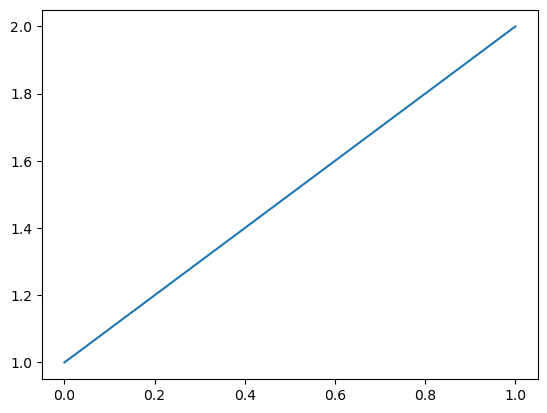

In [1]:
import matplotlib.pyplot as plt
a=[1,2]
plt.plot(a)
plt.show()

In [2]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ResNet as net


In [3]:
# adjustables
dt = 0.01                     # time unit
noise = 0.0      #noise levels: 0.0, 0.01, 0.02, 0.05 ,0.1, 0.2
system = 'KS'         

In [4]:
# path
data_dir = os.path.join('../Data/', system)
model_dir = os.path.join('../models/', system)

# global const
ks = list(range(11))
step_sizes = [2**k for k in ks]

### load data & models

In [5]:
#load validation data set and test set
if system == 'KS':
    val_data = np.load(os.path.join(data_dir, 'data.npy')).T
    mean_values = val_data.mean(0)
    ranges = val_data.ptp(0)
    val_data = (val_data - mean_values)/ranges
    val_data = val_data[None, :, :]


    test_data = np.load(os.path.join(data_dir, 'data.npy')).T
    mean_values = test_data.mean(0)
    ranges = test_data.ptp(0)
    test_data = (test_data - mean_values) / ranges
    test_data = test_data[None, :, :]
else:
    val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))

In [6]:
#load models
models = list()
for step_size in step_sizes:
    print('loading model_D{}.pt'.format(step_size))
    models.append(torch.load(os.path.join(model_dir, 'model_D{}_noise{}.pt'.format(step_size, noise)),map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

loading model_D1.pt
loading model_D2.pt
loading model_D4.pt
loading model_D8.pt
loading model_D16.pt
loading model_D32.pt
loading model_D64.pt
loading model_D128.pt
loading model_D256.pt
loading model_D512.pt
loading model_D1024.pt


### benchmarks

In [8]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [9]:
preds_mse = list()
times = list()
print('uniscale forecasting...')
for model in models:
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
print('prediction recorded!')

uniscale forecasting...
prediction recorded!


In [10]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models_hits = models[start_idx:end_idx]
# multiscale time-stepping with NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models_hits)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

use models 0 - 10.


In [11]:
multiscale_preds_mse.shape

torch.Size([1, 4000])

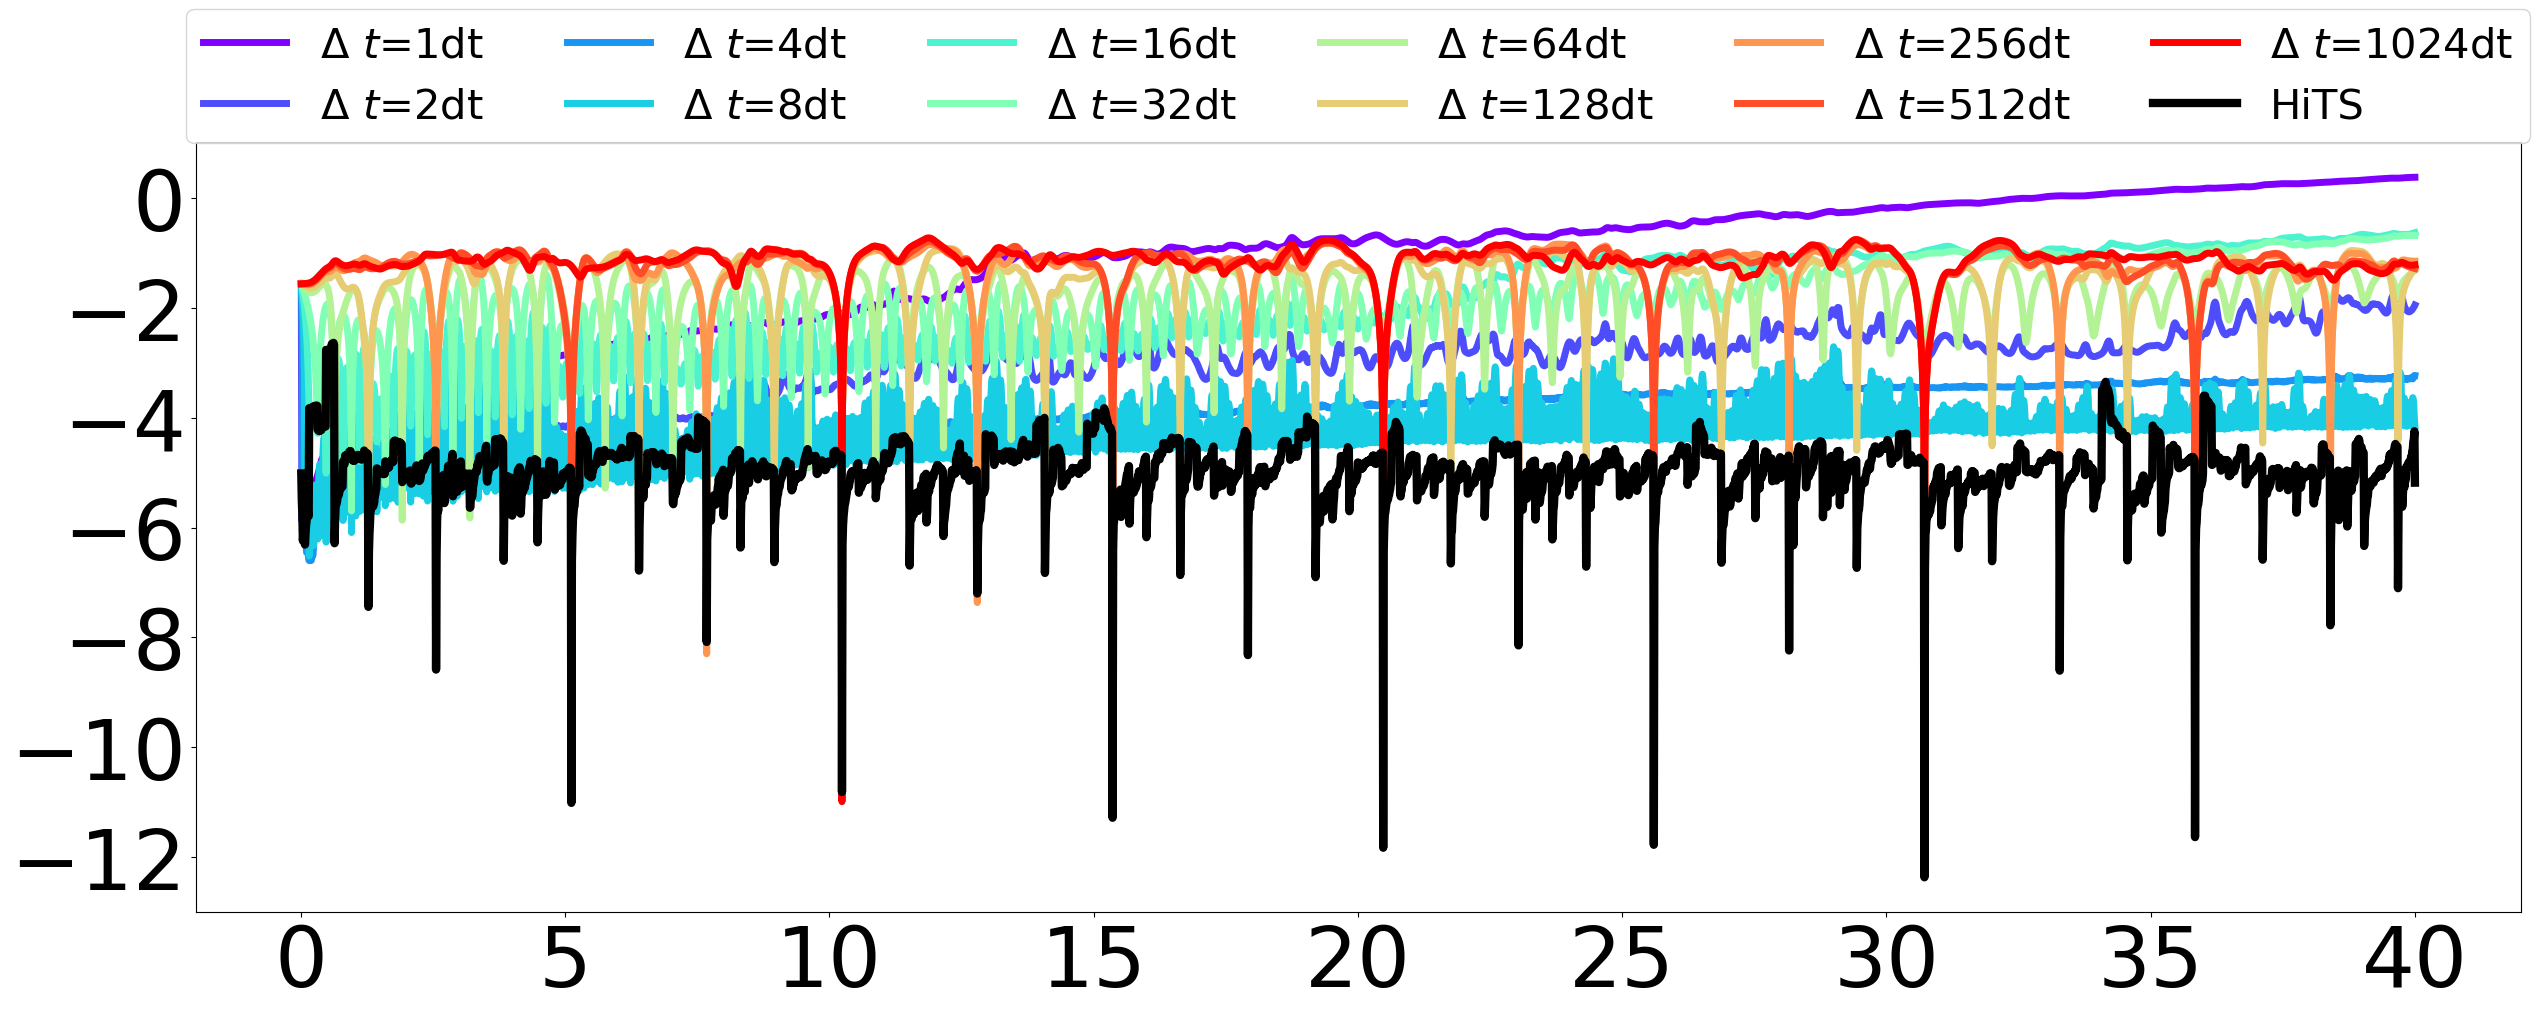

In [12]:
# visualize forecasting error at each time step
norm_uni=list()
nnerr=[]
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
mean_pointwise=list()
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
#Figure1: error plot
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    nnerr.append(mean)
    norm_uni.append(mean.mean())  #mean
    mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.plot(t, np.log10(multiscale_err), linestyle='-', color='k', linewidth=6, label='HiTS')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.savefig('KS2.pdf', bbox_inches='tight')

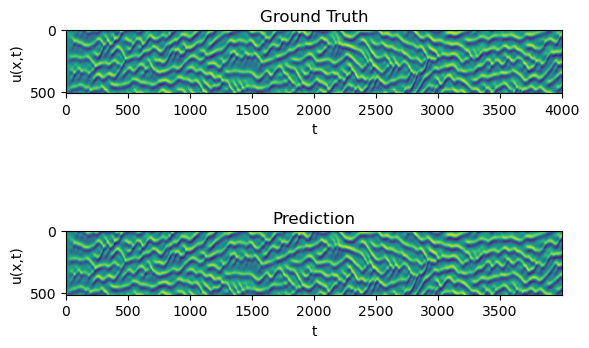

In [12]:
#figure2: Time response
idx = 0 # (you need to change the code here accordingly as state variables are different for different systems)
t = np.linspace(0, (n_steps-1)*dt, n_steps)
if system == 'KS':
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.imshow(np.squeeze(test_data.T))
    ax1.set_title("Ground Truth")
    ax1.set_xlabel('t')
    ax1.set_ylabel('u(x,t)')
    ax2.imshow(np.squeeze(y_preds.T))
    ax2.set_xlabel('t')
    ax2.set_ylabel('u(x,t)')
    ax2.set_title("Prediction")
else:
    fig = plt.figure(figsize=(30, 10))
    gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
    ax0 = fig.add_subplot(gs[0, :])
    if test_data.shape[2]==3:
        ax0.plot(t, test_data[idx, 1:, 0], 'r-', linewidth=10, label='x')
        ax0.plot(t, test_data[idx, 1:, 1], 'g-', linewidth=10, label='y')
        ax0.plot(t, test_data[idx, 1:, 2], 'b-', linewidth=10, label='z') #only in case of Hopf
        ax0.plot(t, y_preds[idx, :n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='HiTs')
        ax0.plot(t, y_preds[idx, :n_steps, 1].detach().numpy(), 'k--', linewidth=10)
        ax0.plot(t, y_preds[idx, :n_steps, 2].detach().numpy(), 'k--', linewidth=10)
    else:
        ax0.plot(t, test_data[idx, 1:, 0], 'r-', linewidth=10, label='x')
        ax0.plot(t, test_data[idx, 1:, 1], 'g-', linewidth=10, label='y')
        ax0.plot(t, y_preds[idx, :n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='HiTs')
        ax0.plot(t, y_preds[idx, :n_steps, 1].detach().numpy(), 'k--', linewidth=10)

    ax0.legend(fontsize=50, loc='upper right')
    ax0.tick_params(axis='both', which='major', labelsize=60)
    plt.show()

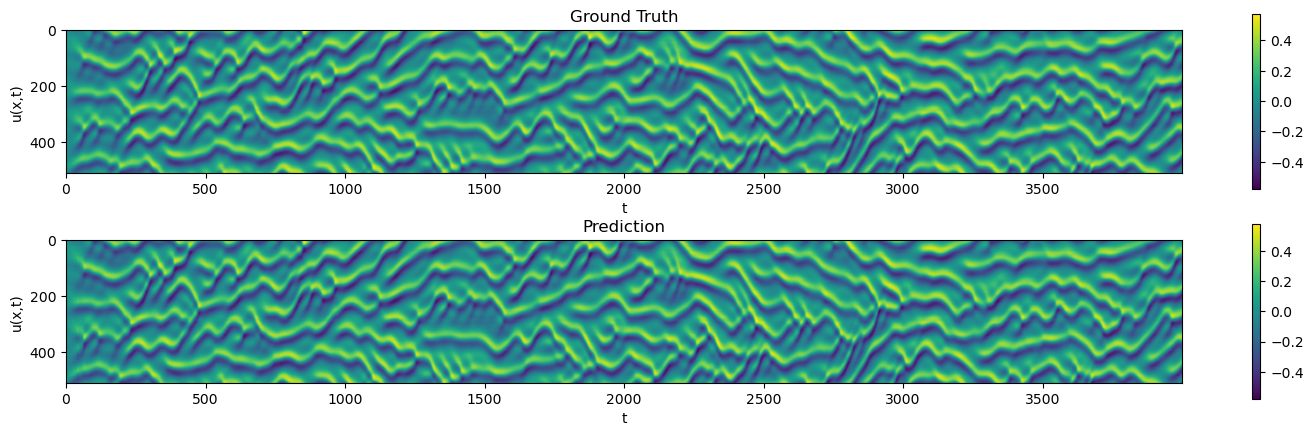

In [13]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18, 5))
img1=ax1.imshow(np.squeeze(test_data[:,1:,:].T))
ax1.set_title("Ground Truth")
ax1.set_xlabel('t')
ax1.set_ylabel('u(x,t)')
fig.colorbar(img1, ax=ax1, shrink=1)
img2=ax2.imshow(np.squeeze(y_preds.T))
ax2.set_xlabel('t')
ax2.set_ylabel('u(x,t)')
ax2.set_title("Prediction")
fig.colorbar(img2, ax=ax2, shrink=1)
plt.savefig('KS1.pdf', bbox_inches='tight')

In [14]:
#computational time
norm_hits=multiscale_err.mean()
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('HiTs:  {}s'.format(multiscale_time))

#norms
norm_uni[0]=preds_mse[0][:,1:].mean()
for i in range(len(norm_uni)):
    print('MSE of NNTS (Dt={}): {}'.format(step_sizes[i]*dt, norm_uni[i]))
print('MSE of AHiTs: {}'.format(norm_hits))

single scaled model (Dt=0.01): computing time 2.151099920272827s
single scaled model (Dt=0.02): computing time 0.9997677803039551s
single scaled model (Dt=0.04): computing time 0.587874174118042s
single scaled model (Dt=0.08): computing time 0.2811856269836426s
single scaled model (Dt=0.16): computing time 0.1805405616760254s
single scaled model (Dt=0.32): computing time 0.062483787536621094s
single scaled model (Dt=0.64): computing time 0.06248641014099121s
single scaled model (Dt=1.28): computing time 0.06248307228088379s
single scaled model (Dt=2.56): computing time 0.046864986419677734s
single scaled model (Dt=5.12): computing time 0.04686927795410156s
single scaled model (Dt=10.24): computing time 0.031241178512573242s
HiTs:  0.22668051719665527s
MSE of NNTS (Dt=0.01): 0.4583877623081207
MSE of NNTS (Dt=0.02): 0.0022261799313127995
MSE of NNTS (Dt=0.04): 0.0002237448061350733
MSE of NNTS (Dt=0.08): 0.00018143608758691698
MSE of NNTS (Dt=0.16): 0.051980044692754745
MSE of NNTS (Dt=

In [15]:
y_preds=y_preds.detach().numpy()

In [57]:
# from scipy.io import savemat
# filename = 'ksresults.mat'
# savemat(filename, {'nnerr': nnerr,'multiscale_err': multiscale_err,'t':t,'test_data':test_data,'y_preds':y_preds})